Задача кластеризации. 
Для начала посмотрим на данные.

In [1]:
import numpy as np
import pandas as pd

In [2]:
dataset = pd.read_excel('Задача.xlsx', engine = 'openpyxl')
dataset

,Персона,"Возраст, лет","Стаж вождения, лет","Убыточность, %","Уровень заработной платы, руб/год"
0,6-LLJEH,20,1,263,716693
1,2-GLHFG,74,51,107,274393
2,6-FJFKL,27,1,165,723841
3,4-KJEJL,24,6,348,139419
4,5-JFFGH,26,3,286,650003
...,...,...,...,...,...
479,3-HKHKE,67,31,102,3630438
480,8-HKKJM,67,44,189,232022
481,8-JGKHL,20,5,285,622134
482,4-EFGJJ,49,38,65,3607848


Заметим, что первый столбец не несет полезной информации. 
Для удобства графического отображения, уменьшим размерность до 2-х. Используем для этого PCA.

In [3]:
from sklearn.decomposition import PCA

pca = PCA(4) # Делаем анализ для 4-х измерений. При необходимости будем использовать только первые две компоненты.
X = np.array(dataset.iloc[:,1:]) # Убираем первый столбец и создаем числовую матрицу
X_std = [X[:,i].std() for i in range(4)] # Находим квадратичные отклонения для каждого столбца.
X_scaled = X / np.array(X_std) # Масштабируем наши данные.

pca.fit(X_scaled) # Находим главные компоненты

print("Eigenvectors:")
print(pca.components_)
print("\nEigenvalues:")
print(pca.explained_variance_ratio_)

Eigenvectors:
[[-0.5641512  -0.55115946  0.50617709 -0.34891464]
 [-0.36891858 -0.42471637 -0.36091114  0.74381331]
 [ 0.21555109  0.13972572  0.78293831  0.56658809]
 [ 0.7065198  -0.70449697 -0.02314106 -0.0630736 ]]

Eigenvalues:
[0.64041496 0.26181602 0.08451246 0.01325657]


На первые две компоненты приходится 90% дисперсии.

In [4]:
X_pca_comp = pca.components_
X_pca = X_scaled.dot(X_pca_comp.T) # Проекция данных на главные компоненты

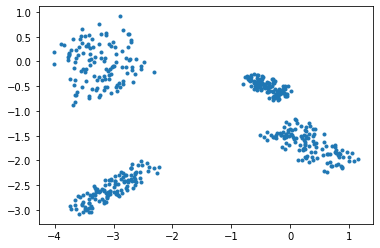

In [5]:
import matplotlib.pyplot as plt

# Построим точки в 2-х мерном пространстве
plt.plot(X_pca.T[0], X_pca.T[1], '.')

Очевидно у нас 4 кластера. Для начала, используем алгоритм Kmeans для нахождения центров. С помощью него же можно убедиться, что кластеров именно 4. 

In [6]:
from sklearn.cluster import KMeans

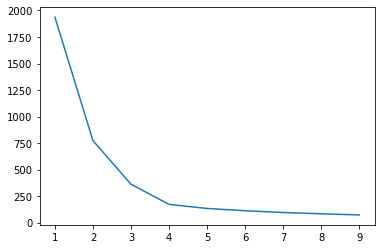

In [7]:
# Проверим количество кластеров

inertia = []
for n in range(1,10):
    kmeans = KMeans(n_clusters = n, random_state = 0)
    kmeans.fit(X_pca)
    inertia.append(kmeans.inertia_)

plt.plot(range(1,10), inertia)

По графику видно, что после n = 4 спада в инерции практически не наблюдается.
Далее ведем расчет для 4-х кластеров.

In [8]:
kmeans = KMeans(n_clusters = 4, random_state = 0)
kmeans.fit(X_pca)

X_centers_kmeans = kmeans.cluster_centers_ # Центры кластеров

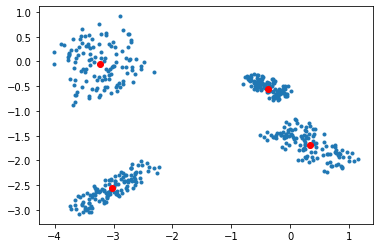

In [9]:
# Построим точки данных с центрами кластеров
plt.plot(X_pca.T[0], X_pca.T[1], '.')
plt.plot(X_centers_kmeans.T[0], X_centers_kmeans.T[1], 'ro')

Посмотрим, как алгоритм разделил точки на кластеры.

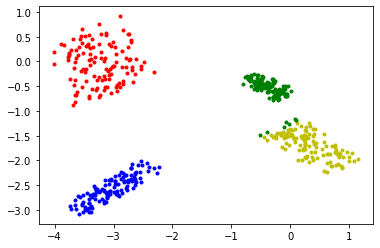

In [10]:
# Для каждого кластера создадим отдельный список [True, False...] длиной равной количеству точек.
# True означает, что данная точка принадлежит данному кластеру
labels = [[kmeans.labels_[i] == j for i in range(484)] for j in range(4)]

colors = ['b', 'r', 'y', 'g']

for i in range(4):
    plt.plot(X_pca[labels[i]].T[0], X_pca[labels[i]].T[1], '.', color = colors[i])


Проведем аналогичный анализ используя Gaussian Mixture Model и EM алгоритм.

In [11]:
from sklearn.mixture import GaussianMixture
gm = GaussianMixture(4, random_state = 0)
gm.fit(X_pca)

GaussianMixture(n_components=4, random_state=0)

In [12]:
gm.weights_ # [0.25, 0.25, 0.25, 0.25] Все кластеры получились равновесны

array([0.25, 0.25, 0.25, 0.25])

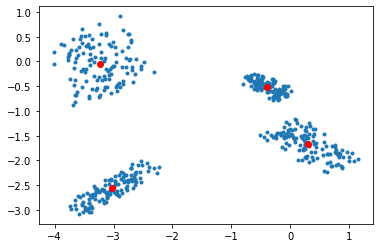

In [13]:
# Посмотрим, где получились центры
plt.plot(X_pca.T[0], X_pca.T[1], '.')
plt.plot(gm.means_.T[0], gm.means_.T[1], 'ro')

Посмотрим, как алгоритм разбил точки на кластеры и как примерно выглядит каждое распределение.

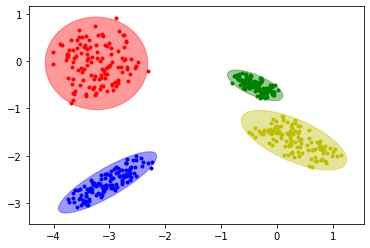

In [15]:
from matplotlib.patches import Ellipse

X_gm_labels = gm.predict(X_pca) # Разбиение точек по кластерам
gml = [[X_gm_labels[i] == j for i in range(484)] for j in range(4)] # Аналогично как для Kmeans создаем списки принадлежности точек к кластерам

fig, ax = plt.subplots()

for i in range(4):
    covariances = gm.covariances_[i][:2,:2] # Матрица корреляций для 2-х мерного распределения
    v, w = np.linalg.eigh(covariances) # Вычленение собственных значений и векторов для построения эллипсов распределений
    angle = np.arctan2(w[0][1], w[0][0]) # Угол наклона эллипса
    angle = 180 * angle / np.pi 
    v = 5 * np.sqrt(v) # Масштабируем распределение, чтобы лучше его видеть
    ell = Ellipse(gm.means_[:,:2][i], v[0], v[1], 180 + angle, alpha = 0.4, color = colors[i])
    ax.add_patch(ell)
    ax.plot(X_pca[gml[i]].T[0], X_pca[gml[i]].T[1], '.', color = colors[i])